In [41]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import json
import sys
import os

sys.path.insert(0,'/Users/tiagorodrigues/Documents/GitHub/NeuroKit')
import neurokit2 as nk
import scipy

# 1. Create HDF5 with the  subgroups and attributes
with annotated R-peaks from kalidas

In [43]:
# Transform all .txt files into .hdf5 OpenSignals readable files

# choose directory path for the .txt files
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana"
sampling_rate = 250

for filename in os.listdir(directory):
    
    #if filename.endswith(".txt") : 
    
    # go through only 1 recording
    if filename.endswith(".txt"):
        
        # run through all files in the folder
        id_record = filename[:-4]
        name_hdf5 = id_record + ".hdf5"
        
        # get ECG
        path = os.path.join(directory, filename)
        ecg = np.genfromtxt(path,skip_header = 4) 
        
        # create hdf5 file
        hf = h5py.File(name_hdf5, 'w')
        
        # add attributes to the file
        hf.attrs.create('delete','{"list": ["/events/ECG/raw/ecg/N"]}')
        hf.attrs.create('repack',data=1, dtype = np.bool)

        # create subgroups
        signals = hf.create_group('signals/ECG/raw')

        
        # max/min for plot lim               
        ecgdataset = signals.create_dataset('ecg',data = ecg)
        ecg_max = max(ecg)
        ecg_min = min(ecg)

        ecgdataset.attrs.create('json','{"name": "signal0", "resolution": 16, "labels": ["ecg"], "units": {"signal": {"max": %f, "min": %f}, "time": {"label": "second"}}, "sampleRate": %d, "type": "/ECG/raw/ecg"}' %(ecg_max,ecg_min,sampling_rate))

        
        
        # Invert polarity for engzee to work
        ecg = ecg * (-1)
        
        detector_peaks = nk.ecg_findpeaks(6, 4, ecg, sampling_rate = 250, method = 'engzee', show = False)
        detected_peaks = np.asarray(detector_peaks['ECG_R_Peaks'])


        # add detected R-peaks
        # detected_peaks = _ecg_findpeaks_kalidas(ecg,250)
        # detected_peaks = [x - 3 for x in detected_peaks]
        
        
        # double collumn for the software, SignalBit assumes each event as a pair [t1,t2]
        detected2_peaks =  np.transpose([detected_peaks, detected_peaks])
                
        #dt = h5py.string_dtype(encoding='ascii')
        events = hf.create_group('events/ECG/raw/ecg/N')
        events.attrs.create('json','{"color": "#ff2600", "annotationType": "line/region", "type": "/ECG/raw/ecg","label": "N"}')
        timestamps = events.create_dataset('timeStamps',data = detected2_peaks)
        values = events.create_dataset('values', data=h5py.Empty("f"))
        
        hf.close() 
        continue

In [3]:
def _ecg_findpeaks_kalidas(signal, sampling_rate=1000):
    """From https://github.com/berndporr/py-ecg-detectors/

    - Vignesh Kalidas and Lakshman Tamil (2017). Real-time QRS detector using Stationary Wavelet Transform
      for Automated ECG Analysis. In: 2017 IEEE 17th International Conference on Bioinformatics and
      Bioengineering (BIBE). Uses the Pan and Tompkins thresolding.

    """
    # Try loading pywt
    try:
        import pywt
    except ImportError:
        raise ImportError(
            "NeuroKit error: ecg_findpeaks(): the 'PyWavelets' module is required for"
            " this method to run. Please install it first (`pip install PyWavelets`)."
        )

    swt_level = 3
    padding = -1
    for i in range(1000):
        if (len(signal) + i) % 2 ** swt_level == 0:
            padding = i
            break

    if padding > 0:
        signal = np.pad(signal, (0, padding), "edge")
    elif padding == -1:
        print("Padding greater than 1000 required\n")

    swt_ecg = pywt.swt(signal, "db3", level=swt_level)
    swt_ecg = np.array(swt_ecg)
    swt_ecg = swt_ecg[0, 1, :]

    squared = swt_ecg * swt_ecg

    f1 = 0.01 / sampling_rate
    f2 = 10 / sampling_rate

    b, a = scipy.signal.butter(3, [f1 * 2, f2 * 2], btype="bandpass")
    filtered_squared = scipy.signal.lfilter(b, a, squared)

    filt_peaks = _ecg_findpeaks_peakdetect(filtered_squared, sampling_rate)

    filt_peaks = np.array(filt_peaks, dtype="int")
    return filt_peaks


In [4]:
def _ecg_findpeaks_MWA(signal, window_size):
    """From https://github.com/berndporr/py-ecg-detectors/
    """

    mwa = np.zeros(len(signal))
    sums = np.cumsum(signal)

    def get_mean(begin, end):
        if begin == 0:
            return sums[end - 1] / end

        dif = sums[end - 1] - sums[begin - 1]
        return dif / (end - begin)

    for i in range(len(signal)):  # pylint: disable=C0200
        if i < window_size:
            section = signal[0:i]
        else:
            section = get_mean(i - window_size, i)

        if i != 0:
            mwa[i] = np.mean(section)
        else:
            mwa[i] = signal[i]

    return mwa


def _ecg_findpeaks_peakdetect(detection, sampling_rate=1000):
    """From https://github.com/berndporr/py-ecg-detectors/
    """
    min_distance = int(0.25 * sampling_rate)

    signal_peaks = [0]
    noise_peaks = []

    SPKI = 0.0
    NPKI = 0.0

    threshold_I1 = 0.0
    threshold_I2 = 0.0

    RR_missed = 0
    index = 0
    indexes = []

    missed_peaks = []
    peaks = []

    for i in range(len(detection)):  # pylint: disable=R1702,C0200

        # pylint: disable=R1716
        if i > 0 and i < len(detection) - 1 and detection[i - 1] < detection[i] and detection[i + 1] < detection[i]:
            peak = i
            peaks.append(peak)  # pylint: disable=R1716
            if detection[peak] > threshold_I1 and (peak - signal_peaks[-1]) > 0.3 * sampling_rate:

                signal_peaks.append(peak)
                indexes.append(index)
                SPKI = 0.125 * detection[signal_peaks[-1]] + 0.875 * SPKI
                if RR_missed != 0 and signal_peaks[-1] - signal_peaks[-2] > RR_missed:
                    missed_section_peaks = peaks[indexes[-2] + 1 : indexes[-1]]
                    missed_section_peaks2 = []
                    for missed_peak in missed_section_peaks:
                        if missed_peak - signal_peaks[-2] > min_distance:
                            if signal_peaks[-1] - missed_peak > min_distance:
                                if detection[missed_peak] > threshold_I2:
                                    missed_section_peaks2.append(missed_peak)

                    if missed_section_peaks2:
                        missed_peak = missed_section_peaks2[np.argmax(detection[missed_section_peaks2])]
                        missed_peaks.append(missed_peak)
                        signal_peaks.append(signal_peaks[-1])
                        signal_peaks[-2] = missed_peak

            else:
                noise_peaks.append(peak)
                NPKI = 0.125 * detection[noise_peaks[-1]] + 0.875 * NPKI

            threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
            threshold_I2 = 0.5 * threshold_I1

            if len(signal_peaks) > 8:
                RR = np.diff(signal_peaks[-9:])
                RR_ave = int(np.mean(RR))
                RR_missed = int(1.66 * RR_ave)

            index += 1

    signal_peaks.pop(0)

    return signal_peaks

[100000, 101000, -500, 500]

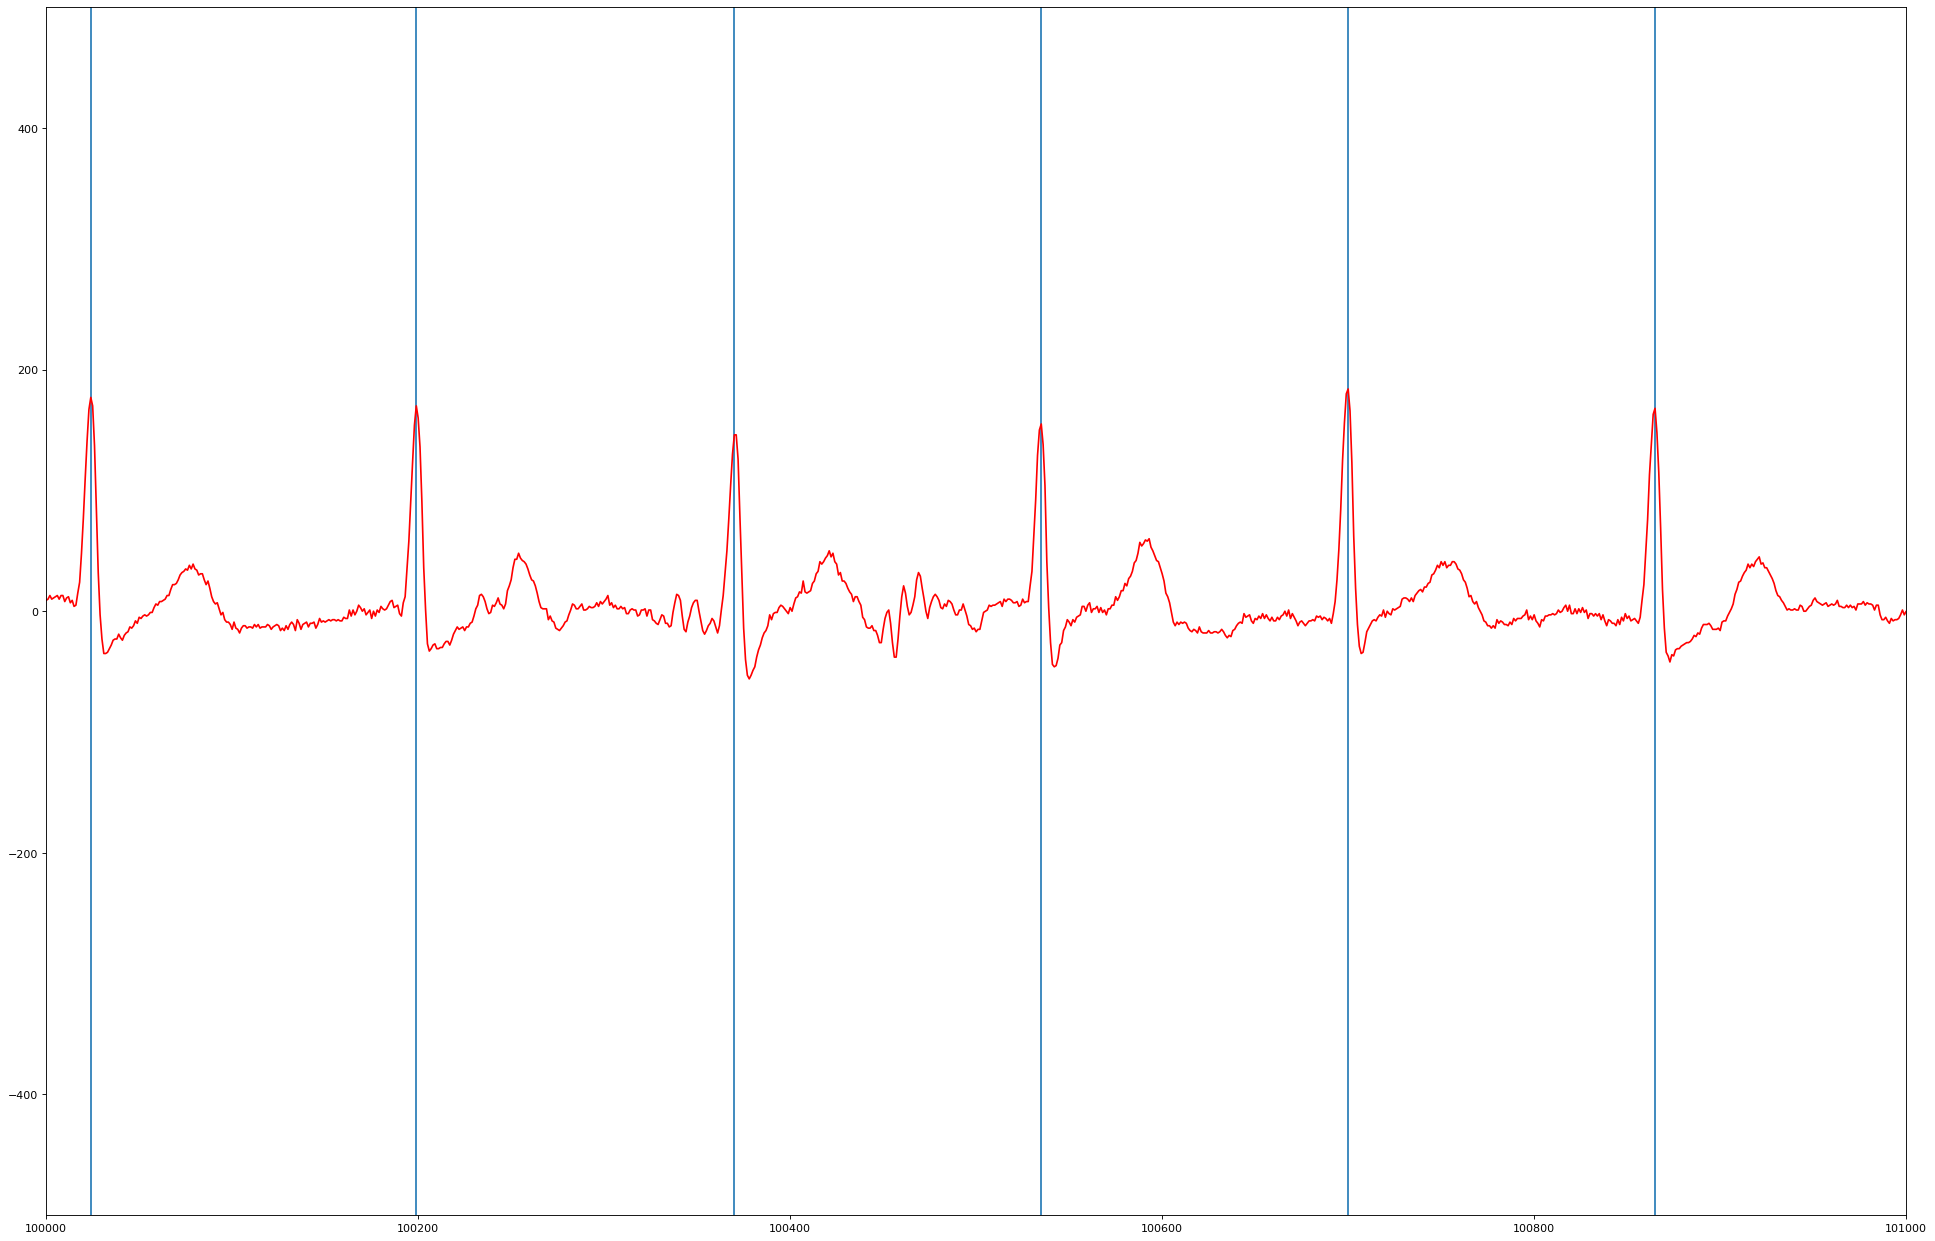

In [39]:
detector_peaks = nk.ecg_findpeaks(6, 4, ecg, sampling_rate = 250, method = 'engzee', show = False)
timestamps_detector = np.asarray(detector_peaks['ECG_R_Peaks'])



plt.figure(figsize=(30, 20), dpi=80, facecolor='w', edgecolor='k')
for xc in timestamps_detector:
    plt.axvline(x=xc)
plt.plot(ecg,'r')
plt.axis([100000,101000,-500,500])
